In [26]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from notebooks.imports import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import warnings
# suppress warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import statsmodels.stats.api as sms

import src.utils.setup_figures as figures
import src.utils.basic as utils

In [51]:
from config import dir_config, main_config

base_data_dir = Path(dir_config.data.base)
raw_dir = Path(dir_config.data.raw)
processed_dir = Path(dir_config.data.processed)

data = pd.read_csv(Path(processed_dir, "processed_data60accu_allowed.csv"), index_col=None)
processed_metadata = pd.read_csv(Path(processed_dir, "processed_metadata_60accu_allowed.csv"), index_col=None)

# exclude the following subjects where categorization score is more than 3
reject_subs = processed_metadata.loc[processed_metadata["categorization_score"] > 3]['subject_id']
processed_metadata = processed_metadata.loc[~processed_metadata["subject_id"].isin(reject_subs)]


In [52]:
processed_metadata['subject_id'].unique(), processed_metadata['subject_id'].unique().shape

(array(['P1', 'P4', 'P6', 'P7', 'P9', 'P11', 'P13', 'P17', 'P18', 'P19',
        'P20', 'P22', 'P23', 'P24', 'CG', 'COH', 'MBY', 'DP', 'FUR', 'LBR',
        'MAR', 'SMI', 'PAM', 'RW', 'SGA', 'BBK', 'BER', 'RBA', 'RDE'],
       dtype=object),
 (29,))

In [53]:
data['subject'].unique()

array(['CG', 'COH', 'LHO', 'MBY', 'P1', 'P22', 'P23', 'P24', 'PAM', 'RBA',
       'RDE', 'RW', 'SGA', 'ALE', 'BBK', 'BER', 'DP', 'FUR', 'LBR', 'MAR',
       'P10', 'P11', 'P12', 'P13', 'P16', 'P17', 'P18', 'P19', 'P20',
       'P3', 'P4', 'P6', 'P7', 'P9', 'SMI'], dtype=object)

In [54]:
# Getting indices of on and off treatment from same subject in processed metadata
subject_treatment_idx = pd.DataFrame(columns=['subject', 'off', 'on'])
subtype_idx = pd.DataFrame(columns=['subject', 'off', 'on'])

for idx, sub in enumerate(processed_metadata['subject_id'].unique()):
    sub_df = processed_metadata.loc[processed_metadata['subject_id'] == sub]
    subject_treatment_idx.loc[idx] = [sub, sub_df.loc[sub_df['treatment'] == 'OFF'].index[0], sub_df.loc[sub_df['treatment'] == 'ON'].index[0]]

    # print(f"Subject {sub} with {sub_df['subject_id'].values}")
    print(f"Subject {sub} has {sub_df['categorization_score'].values} categorization_score")
    if np.sum(np.isnan(sub_df['categorization_score'])) == 0:
        # put off treatment first column and on treatment second column one row at a time
        subtype_idx.loc[idx] = [sub, sub_df.loc[sub_df['treatment'] == 'OFF'].index[0], sub_df.loc[sub_df['treatment'] == 'ON'].index[0]]
        
    # break

Subject P1 has [0.1958042 0.1958042] categorization_score
Subject P4 has [0.8 0.8] categorization_score
Subject P6 has [1.03896104 1.03896104] categorization_score
Subject P7 has [1.93939394 1.93939394] categorization_score
Subject P9 has [0.58181818 0.58181818] categorization_score
Subject P11 has [1.33333333 1.33333333] categorization_score
Subject P13 has [0.43636364 0.43636364] categorization_score
Subject P17 has [1.00699301 1.00699301] categorization_score
Subject P18 has [1.09090909 1.09090909] categorization_score
Subject P19 has [1.11363636 1.11363636] categorization_score
Subject P20 has [0.35109718 0.35109718] categorization_score
Subject P22 has [0.0969697 0.0969697] categorization_score
Subject P23 has [0.15311005 0.15311005] categorization_score
Subject P24 has [0.93506494 0.93506494] categorization_score
Subject CG has [nan nan] categorization_score
Subject COH has [nan nan] categorization_score
Subject MBY has [nan nan] categorization_score
Subject DP has [nan nan] cate

In [55]:
subtype_idx

,subject,off,on
0,P1,0,1
1,P4,2,3
2,P6,4,5
3,P7,6,7
4,P9,9,8
5,P11,11,10
6,P13,14,15
7,P17,18,19
8,P18,21,20
9,P19,23,22


In [56]:
original_all_subjects = ['CG', 'COH', 'MBY', 'DP', 'FUR', 'LBR', 'MAR', 'SMI', 'RW', 'SGA']
original_trem_subjects = ['DP', 'FUR', 'LBR', 'MAR', 'SMI']
original_brady_subjects = ['CG', 'COH', 'MBY', 'RW', 'SGA']

new_trem_subjects = processed_metadata.loc[processed_metadata['categorization'] == 'tremor_dominant']['subject_id'].unique()
new_brady_subjects = processed_metadata.loc[processed_metadata['categorization'] == 'bradykinesia_dominant']['subject_id'].unique()
new_intermediate_subjects = processed_metadata.loc[processed_metadata['categorization'] == 'intermediate']['subject_id'].unique()
print(f"New tremor_subjects: {len(new_trem_subjects)} \t {new_trem_subjects}")
print(f"New brady_subjects: {len(new_brady_subjects)} \t{new_brady_subjects}")
print(f"New intermediate_subjects: {len(new_intermediate_subjects)} \t{new_intermediate_subjects}")

new_all_subjects = subject_treatment_idx['subject'].unique()
new_subtype_subjects = subtype_idx['subject'].unique()
# print(f"New all_subjects: {new_all_subjects}")
# print(f"New subtype_subjects: {new_subtype_subjects}")

New tremor_subjects: 6 	 ['P6' 'P7' 'P11' 'P17' 'P18' 'P19']
New brady_subjects: 7 	['P1' 'P4' 'P9' 'P13' 'P20' 'P22' 'P23']
New intermediate_subjects: 1 	['P24']


### Psychometric Function plots

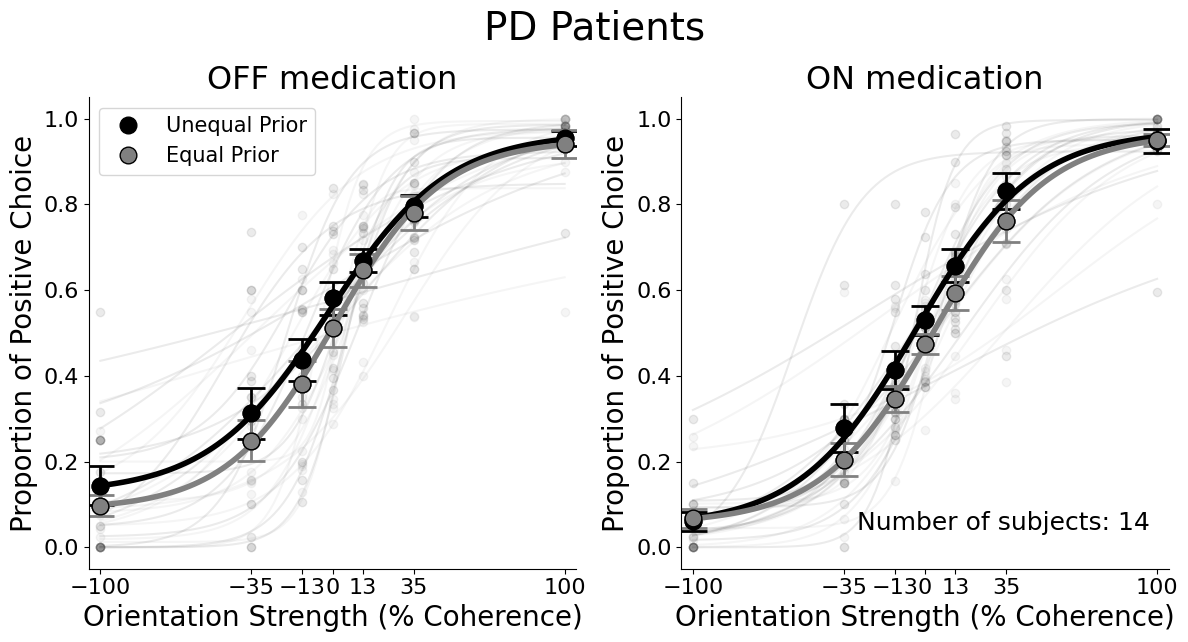

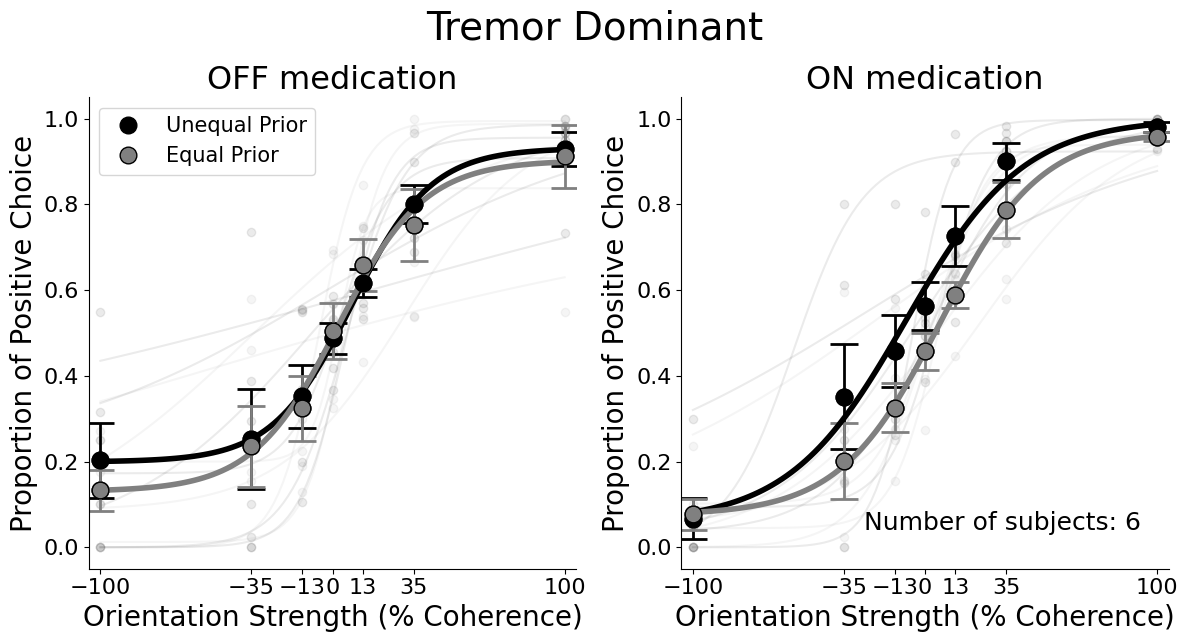

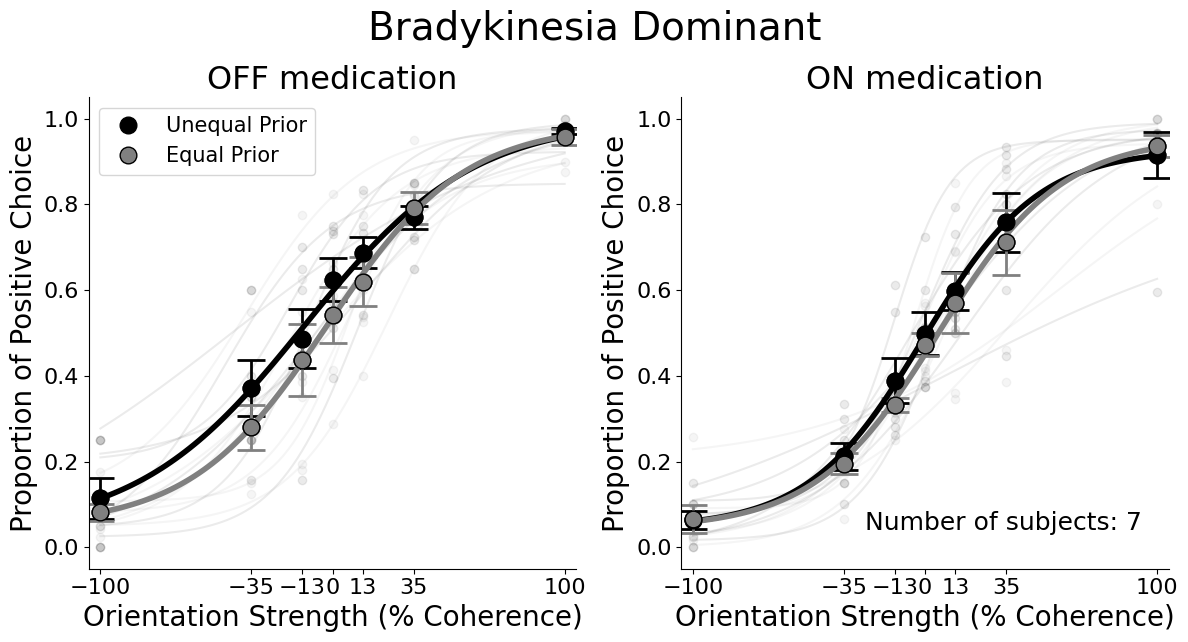

In [59]:
# for each subject, plot psychometric function for on and off medication sessions for positive and negative colors

for category in ['all', 'tremor_dominant', 'bradykinesia_dominant']:
# for category in ['tremor_dominant', 'bradykinesia_dominant']:
    
    if category == 'all':
        subjects = np.concatenate([new_brady_subjects, new_trem_subjects, new_intermediate_subjects])#, original_all_subjects])
        subtitle = 'PD Patients'
    elif category == 'tremor_dominant':
        subjects = new_trem_subjects
        subtitle = 'Tremor Dominant'
    elif category == 'bradykinesia_dominant':
        subjects = new_brady_subjects
        subtitle = 'Bradykinesia Dominant'

    fig, ax = plt.subplots(1, 2, figsize=(12, 6.5))
    subject_alpha = 0.08
    positive_color = 'black'# 'C5'
    equal_color = 'gray'
    error_plot_style = {'elinewidth': 2, 'capsize': 10, 'capthick': 2}

    sub_off_pos_coh, sub_off_pos_psych, sub_off_pos_model, sub_off_pos_x_hat, sub_off_pos_y_hat = [], [], [], [], []
    sub_off_eq_coh, sub_off_eq_psych, sub_off_eq_model, sub_off_eq_x_hat, sub_off_eq_y_hat = [], [], [], [], []
    sub_on_pos_coh, sub_on_pos_psych, sub_on_pos_model, sub_on_pos_x_hat, sub_on_pos_y_hat = [], [], [], [], []
    sub_on_eq_coh, sub_on_eq_psych, sub_on_eq_model, sub_on_eq_x_hat, sub_on_eq_y_hat = [], [], [], [], []

    for i, subject in enumerate(subjects):
        subject_data = data[data['subject'] == subject]
        subject_data = subject_data.sort_values('medication')
        
        for idx, med in enumerate(subject_data['medication'].unique()):
            med_data = subject_data[subject_data['medication'] == med]
            pos_coh, pos_psych, pos_model, pos_x_hat, pos_y_hat = utils.get_psychometric_data(med_data[med_data['color'] == 1])
            eq_coh, eq_psych, eq_model, eq_x_hat, eq_y_hat  = utils.get_psychometric_data(med_data[med_data['color'] == -1])

            if med == 'off':            
                ax_idx = 0
                sub_off_pos_coh.append(pos_coh)
                sub_off_pos_psych.append(pos_psych)
                sub_off_pos_model.append(pos_model)
                sub_off_pos_x_hat.append(pos_x_hat)
                sub_off_pos_y_hat.append(pos_y_hat)            
                sub_off_eq_coh.append(eq_coh)
                sub_off_eq_psych.append(eq_psych)
                sub_off_eq_model.append(eq_model)
                sub_off_eq_x_hat.append(eq_x_hat)
                sub_off_eq_y_hat.append(eq_y_hat)
            elif med == 'on':            
                ax_idx = 1
                sub_on_pos_coh.append(pos_coh)
                sub_on_pos_psych.append(pos_psych)
                sub_on_pos_model.append(pos_model)
                sub_on_pos_x_hat.append(pos_x_hat)
                sub_on_pos_y_hat.append(pos_y_hat)
                sub_on_eq_coh.append(eq_coh)
                sub_on_eq_psych.append(eq_psych)
                sub_on_eq_model.append(eq_model)
                sub_on_eq_x_hat.append(eq_x_hat)
                sub_on_eq_y_hat.append(eq_y_hat)
            
            ax[ax_idx].plot(pos_coh, pos_psych, color=positive_color, marker='o', ls='', alpha=subject_alpha)
            ax[ax_idx].plot(pos_x_hat, pos_y_hat, color=positive_color, ls='-', alpha=subject_alpha)
            ax[ax_idx].plot(eq_coh, eq_psych, color=equal_color, marker='o', ls='', alpha=subject_alpha)
            ax[ax_idx].plot(eq_x_hat, eq_y_hat, color=equal_color, ls='-', alpha=subject_alpha)


    ax[0].plot(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_psych, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', label='Unequal Prior', alpha=1)
    ax[0].plot(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_psych, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', label='Equal Prior', alpha=1)
    ax[0].errorbar(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_psych, axis=0), yerr=stats.sem(sub_off_pos_psych, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
    ax[0].errorbar(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_psych, axis=0), yerr=stats.sem(sub_off_eq_psych, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
    pos_model = utils.fit_psychometric_function(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_psych, axis=0))
    eq_model = utils.fit_psychometric_function(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_psych, axis=0))
    ax[0].plot(np.mean(sub_off_pos_x_hat, axis=0), pos_model.predict(np.mean(sub_off_pos_x_hat, axis=0)), color=positive_color, ls='-', lw=4, alpha=1)
    ax[0].plot(np.mean(sub_off_eq_x_hat, axis=0), eq_model.predict(np.mean(sub_off_eq_x_hat, axis=0)), color=equal_color, ls='-', lw=4, alpha=1)
    
    
    ax[1].plot(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_psych, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', label='Unequal Prior', alpha=1)
    ax[1].plot(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_psych, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', label='Equal Prior', alpha=1)
    ax[1].errorbar(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_psych, axis=0), yerr=stats.sem(sub_on_pos_psych, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
    ax[1].errorbar(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_psych, axis=0), yerr=stats.sem(sub_on_eq_psych, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
    pos_model = utils.fit_psychometric_function(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_psych, axis=0))
    eq_model = utils.fit_psychometric_function(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_psych, axis=0))
    ax[1].plot(np.mean(sub_on_pos_x_hat, axis=0), pos_model.predict(np.mean(sub_on_pos_x_hat, axis=0)), color=positive_color, ls='-', lw=4, alpha=1)
    ax[1].plot(np.mean(sub_on_eq_x_hat, axis=0), eq_model.predict(np.mean(sub_on_eq_x_hat, axis=0)), color=equal_color, ls='-', lw=4, alpha=1)
    
    
    ax[0].set_title(f"OFF medication", fontsize=23)
    ax[1].set_title(f"ON medication", fontsize=23)
    
    ax[0].legend(fontsize=15)
    
    for i in range(2):
        ax[i].set_xlabel('Orientation Strength (% Coherence)', fontsize=20)
        ax[i].set_ylabel('Proportion of Positive Choice', fontsize=20)
        ax[i].set_xlim(-105, 105)
        ax[i].set_ylim(-0.05, 1.05)
        ax[i].set_xticks([-100, -35, -13, 0, 13, 35, 100])
        ax[i].tick_params(axis='both', labelsize=16)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].grid(False)
    
    fig.suptitle(f"{subtitle}", fontsize=28)
    
    # Add a text annotation with the number of subjects
    fig.text(0.84, 0.18, f"Number of subjects: {len(subjects)}", ha='center', fontsize=18)
    # fig.text(0.35, 0.18, f"Number of subjects: {len(subjects)}", ha='center', fontsize=18)
    
    fig.tight_layout()
    plt.show()



In [14]:
temp_data = data.copy()
# rename response_time to reaction_time
temp_data = temp_data.rename(columns={'reaction_time':'response_time'})

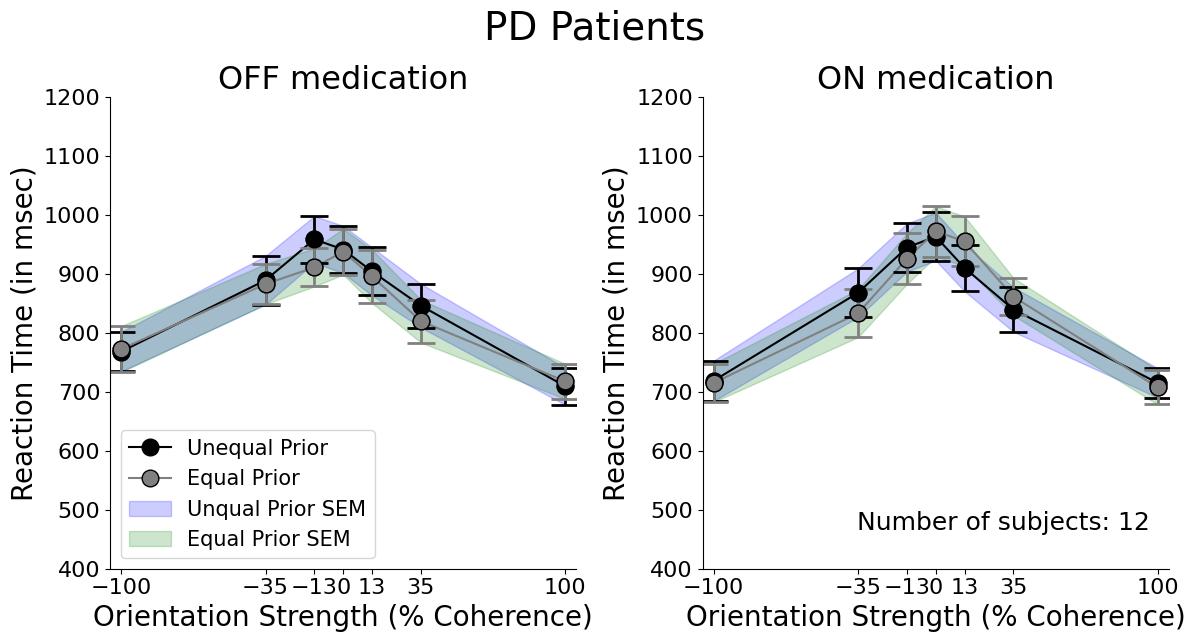

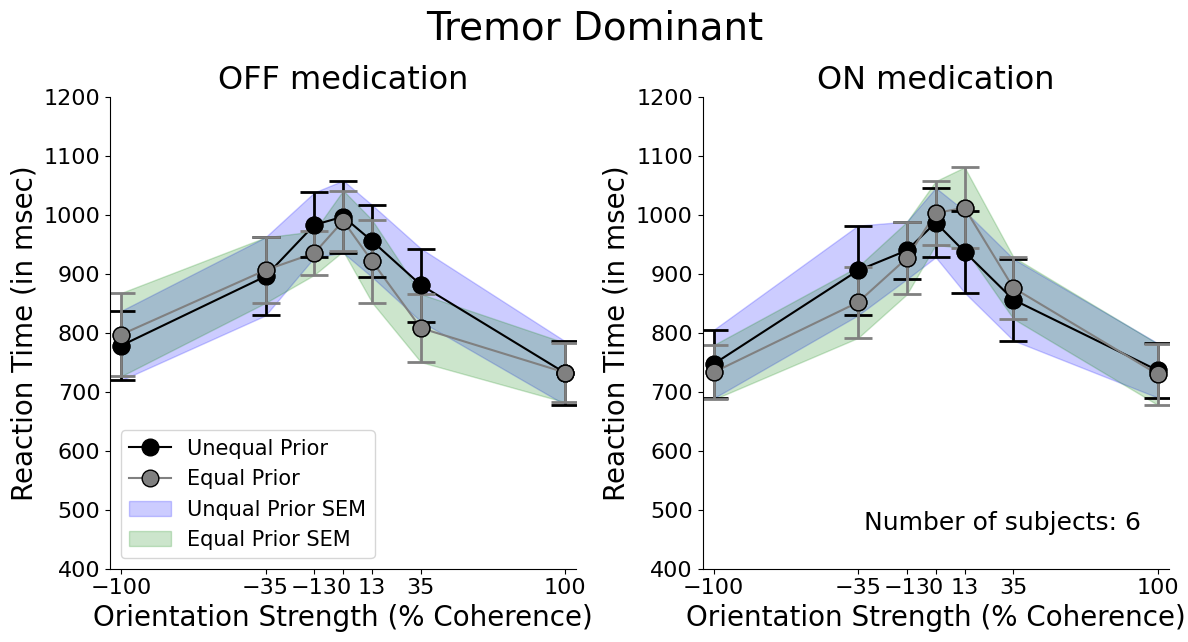

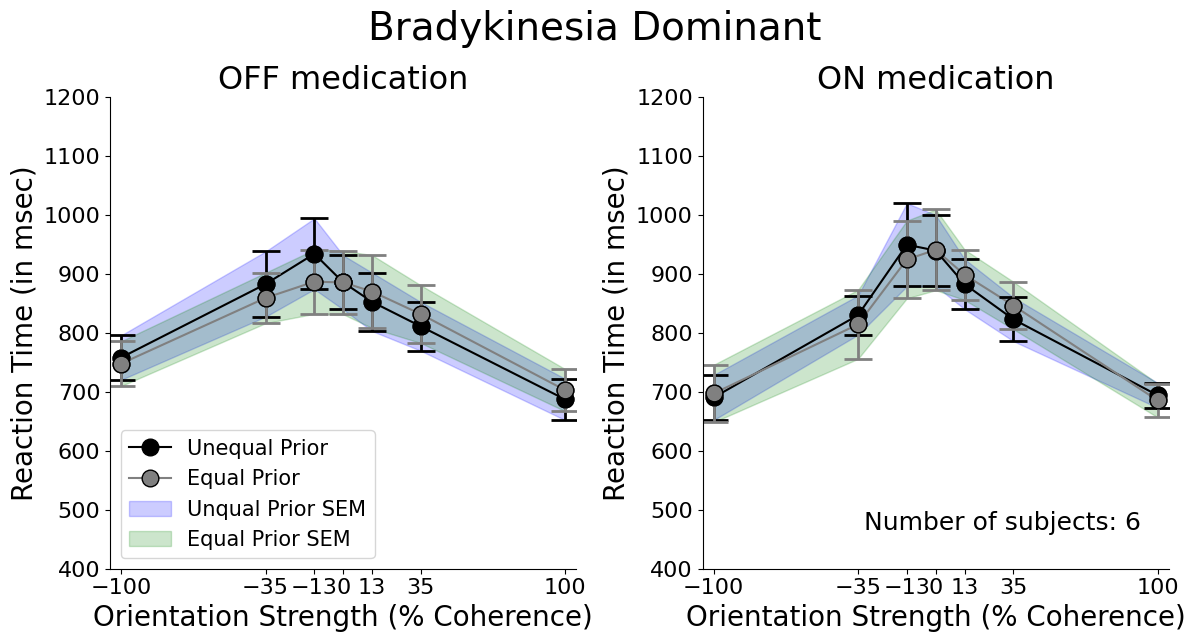

NameError: name 'new_intermediate_subjects' is not defined

In [22]:
# for each subject, plot psychometric function for on and off medication sessions for positive and negative colors

# for category in ['all']:#, 'tremor_dominant', 'bradykinesia_dominant']:
for category in ['all', 'tremor_dominant', 'bradykinesia_dominant']:
    
    if category == 'all':
        subjects = np.concatenate([new_brady_subjects, new_trem_subjects, new_intermediate_subjects])#, original_all_subjects])
        subtitle = 'PD Patients'
    elif category == 'tremor_dominant':
        subjects = new_trem_subjects
        subtitle = 'Tremor Dominant'
    elif category == 'bradykinesia_dominant':
        subjects = new_brady_subjects
        subtitle = 'Bradykinesia Dominant'

    fig, ax = plt.subplots(1, 2, figsize=(12, 6.5))
    subject_alpha = 0.08
    positive_color = 'black'# 'C5'
    equal_color = 'gray'
    error_plot_style = {'elinewidth': 2, 'capsize': 10, 'capthick': 2}

    sub_off_pos_coh, sub_off_pos_chrono = [], []
    sub_off_eq_coh, sub_off_eq_chrono = [], []
    sub_on_pos_coh, sub_on_pos_chrono = [], []
    sub_on_eq_coh, sub_on_eq_chrono = [], []

    for i, subject in enumerate(subjects):
        subject_data = temp_data[temp_data['subject'] == subject]
        subject_data = subject_data.sort_values('medication')
        
        for idx, med in enumerate(subject_data['medication'].unique()):
            med_data = subject_data[subject_data['medication'] == med]
            pos_coh, pos_chrono = utils.get_chronometric_data(med_data[med_data['color'] == 1])
            eq_coh, eq_chrono = utils.get_chronometric_data(med_data[med_data['color'] == -1])

            if med == 'off':            
                ax_idx = 0
                sub_off_pos_coh.append(pos_coh)
                sub_off_pos_chrono.append(pos_chrono)         
                sub_off_eq_coh.append(eq_coh)
                sub_off_eq_chrono.append(eq_chrono)
            elif med == 'on':            
                ax_idx = 1
                sub_on_pos_coh.append(pos_coh)
                sub_on_pos_chrono.append(pos_chrono)         
                sub_on_eq_coh.append(eq_coh)
                sub_on_eq_chrono.append(eq_chrono)
            
            # ax[ax_idx].plot(pos_coh, pos_chrono, color=positive_color, marker='o', ls='', alpha=subject_alpha)
            # ax[ax_idx].plot(eq_coh, eq_chrono, color=equal_color, marker='o', ls='', alpha=subject_alpha)


    ax[0].plot(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_chrono, axis=0), color=positive_color, ls='-', marker='o', ms=12, mec='k', label='Unequal Prior', alpha=1)
    ax[0].plot(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_chrono, axis=0), color=equal_color, ls='-', marker='o', ms=12, mec='k', label='Equal Prior', alpha=1)
    ax[0].errorbar(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_chrono, axis=0), yerr=stats.sem(sub_off_pos_chrono, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
    ax[0].errorbar(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_chrono, axis=0), yerr=stats.sem(sub_off_eq_chrono, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
    # fill between the error bars
    ax[0].fill_between(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_chrono, axis=0) - stats.sem(sub_off_pos_chrono, axis=0), np.mean(sub_off_pos_chrono, axis=0) + stats.sem(sub_off_pos_chrono, axis=0), color='blue', alpha=0.2, label='Unqual Prior SEM')
    ax[0].fill_between(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_chrono, axis=0) - stats.sem(sub_off_eq_chrono, axis=0), np.mean(sub_off_eq_chrono, axis=0) + stats.sem(sub_off_eq_chrono, axis=0), color='green', alpha=0.2, label='Equal Prior SEM')
    
    ax[1].plot(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_chrono, axis=0), color=positive_color, ls='-', marker='o', ms=12, mec='k', label='Unequal Prior', alpha=1)
    ax[1].plot(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_chrono, axis=0), color=equal_color, ls='-', marker='o', ms=12, mec='k', label='Equal Prior', alpha=1)
    ax[1].errorbar(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_chrono, axis=0), yerr=stats.sem(sub_on_pos_chrono, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
    ax[1].errorbar(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_chrono, axis=0), yerr=stats.sem(sub_on_eq_chrono, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
    # fill between the error bars
    ax[1].fill_between(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_chrono, axis=0) - stats.sem(sub_on_pos_chrono, axis=0), np.mean(sub_on_pos_chrono, axis=0) + stats.sem(sub_on_pos_chrono, axis=0), color='blue', alpha=0.2)
    ax[1].fill_between(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_chrono, axis=0) - stats.sem(sub_on_eq_chrono, axis=0), np.mean(sub_on_eq_chrono, axis=0) + stats.sem(sub_on_eq_chrono, axis=0), color='green', alpha=0.2)

    
    ax[0].set_title(f"OFF medication", fontsize=23)
    ax[1].set_title(f"ON medication", fontsize=23)
    
    ax[0].legend(fontsize=15)
    
    for i in range(2):
        ax[i].set_xlabel('Orientation Strength (% Coherence)', fontsize=20)
        ax[i].set_ylabel('Reaction Time (in msec)', fontsize=20)
        ax[i].set_xlim(-105, 105)
        ax[i].set_ylim(400, 1200)
        ax[i].set_xticks([-100, -35, -13, 0, 13, 35, 100])
        ax[i].tick_params(axis='both', labelsize=16)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].grid(False)
    
    fig.suptitle(f"{subtitle}", fontsize=28)
    
    # Add a text annotation with the number of subjects
    fig.text(0.84, 0.18, f"Number of subjects: {len(subjects)}", ha='center', fontsize=18)
    # fig.text(0.35, 0.18, f"Number of subjects: {len(subjects)}", ha='center', fontsize=18)
    
    fig.tight_layout()
    plt.show()



### Perform analysis on bias, alpha, beta, gamma and delta based on categorization_score

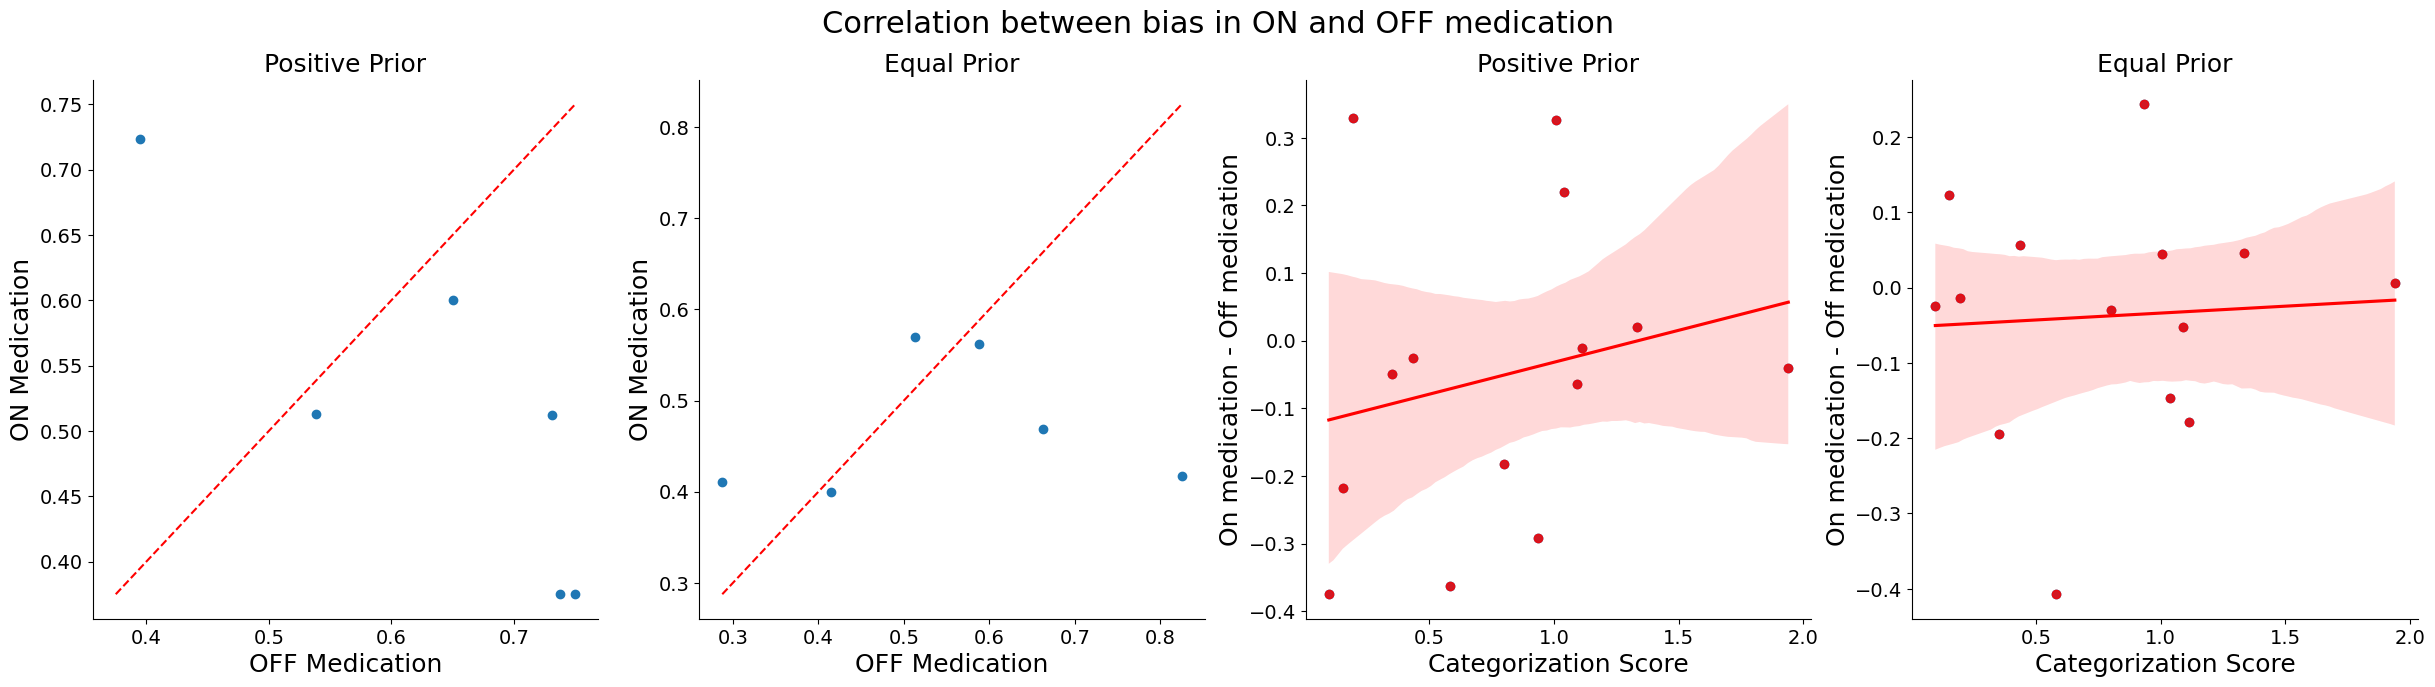

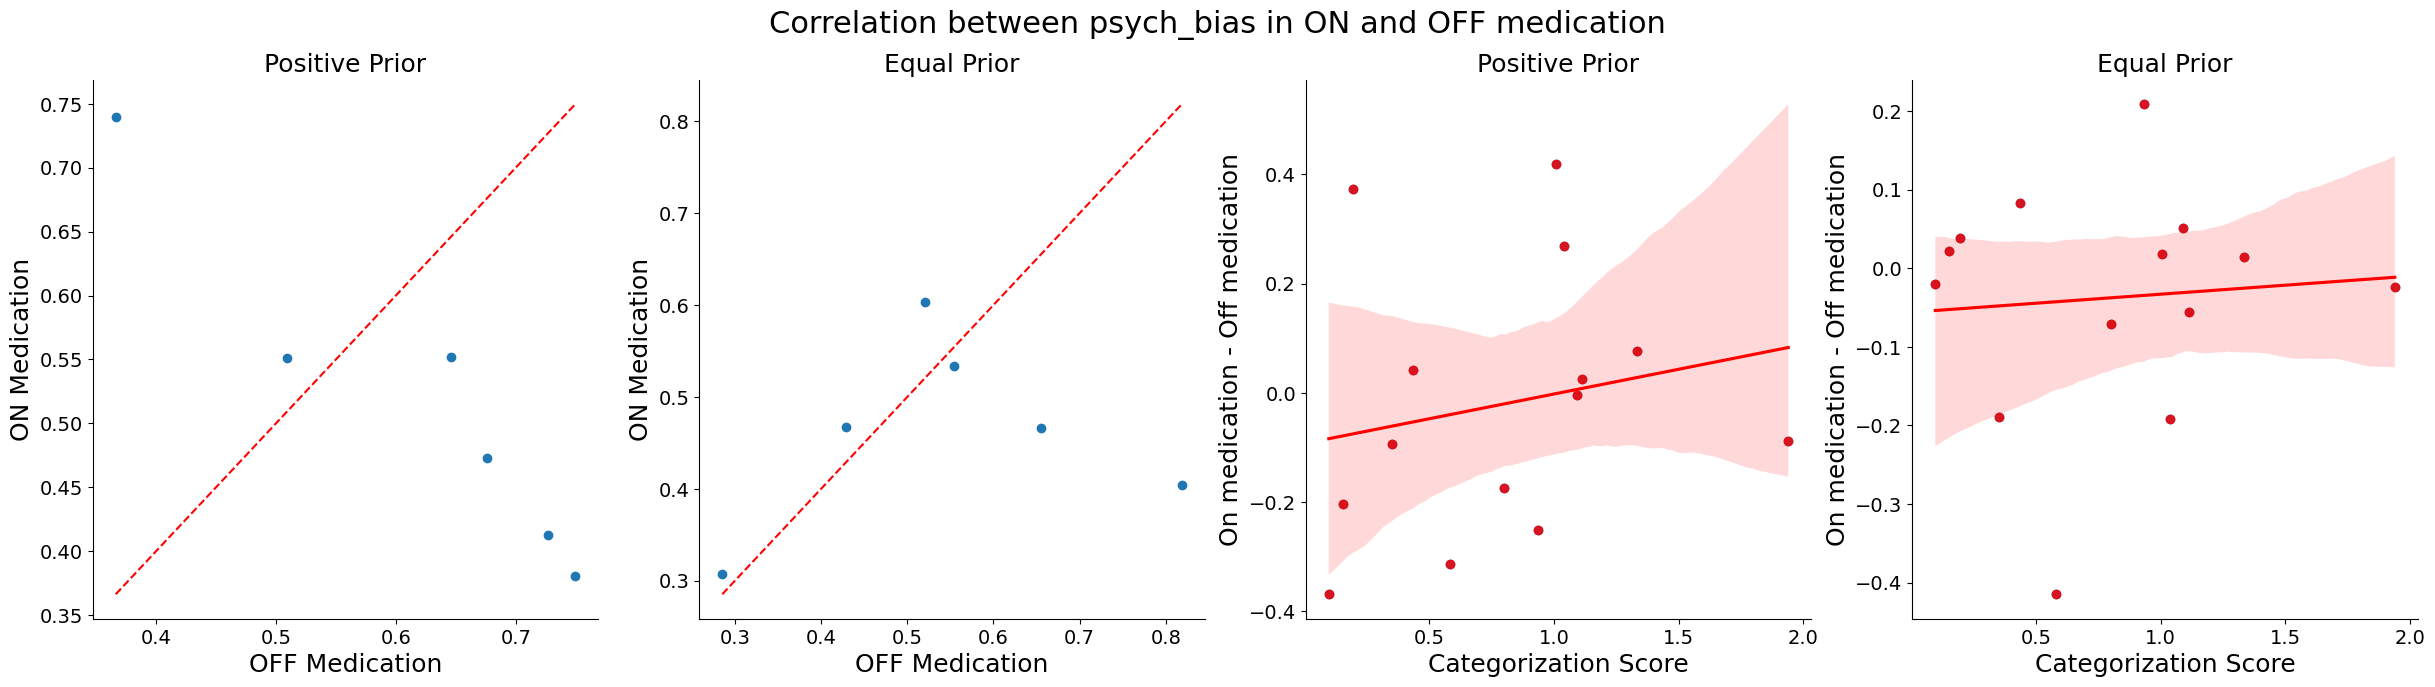

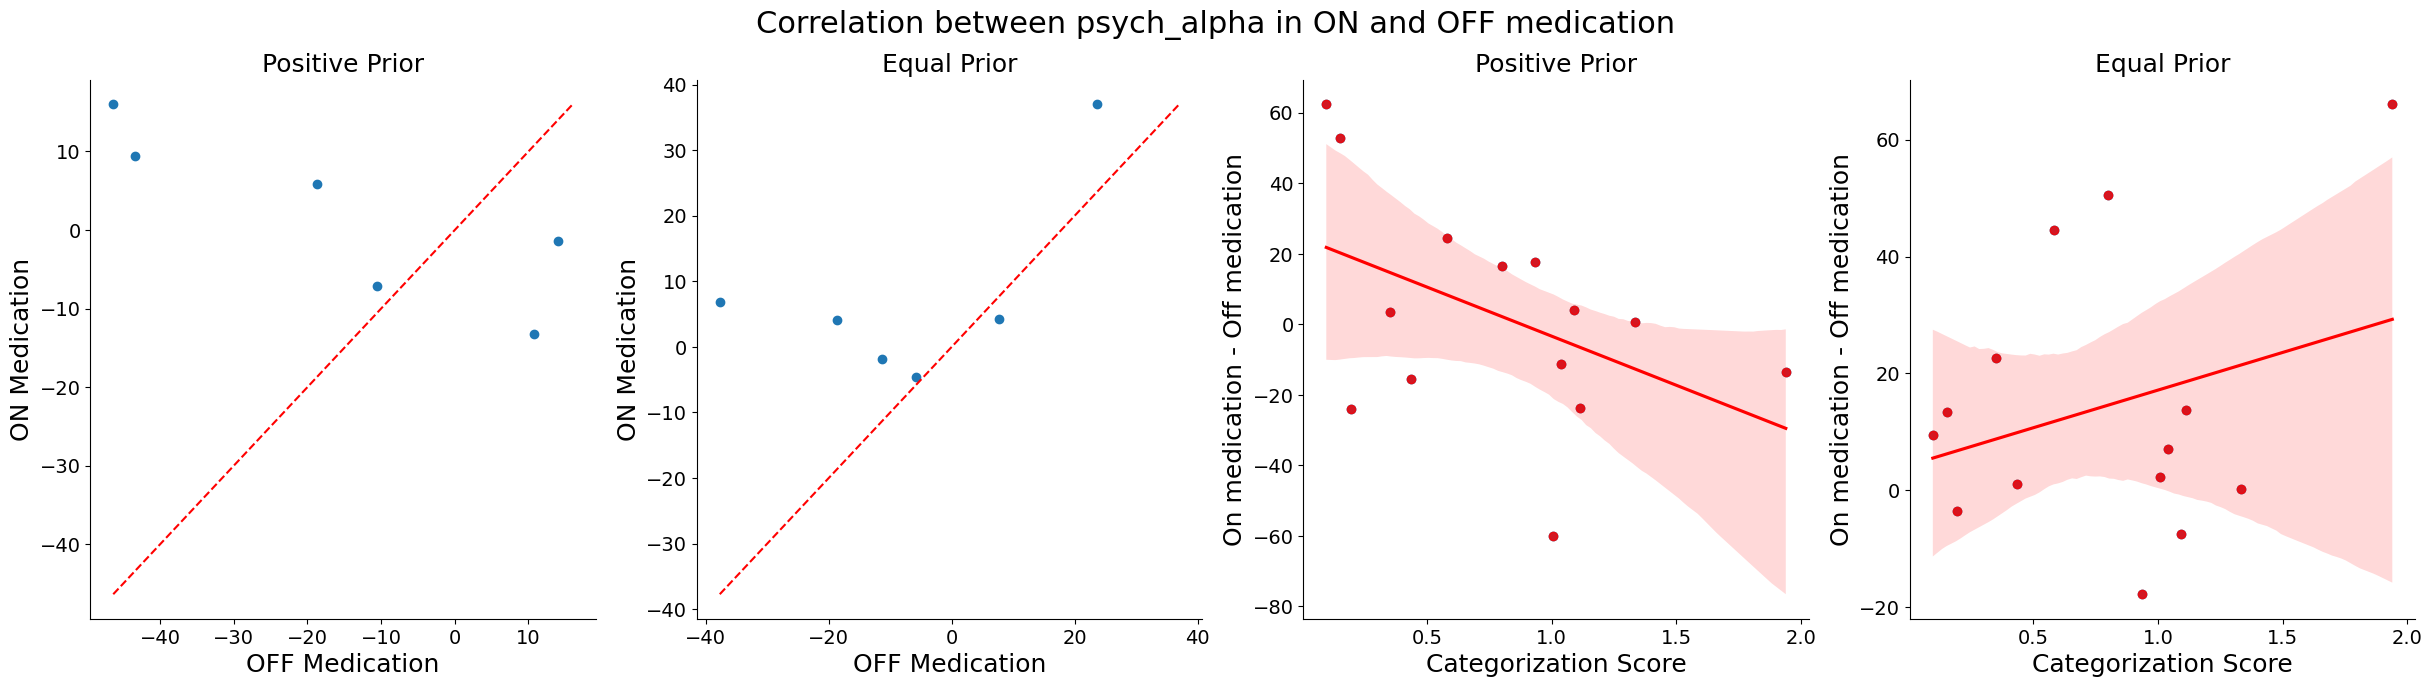

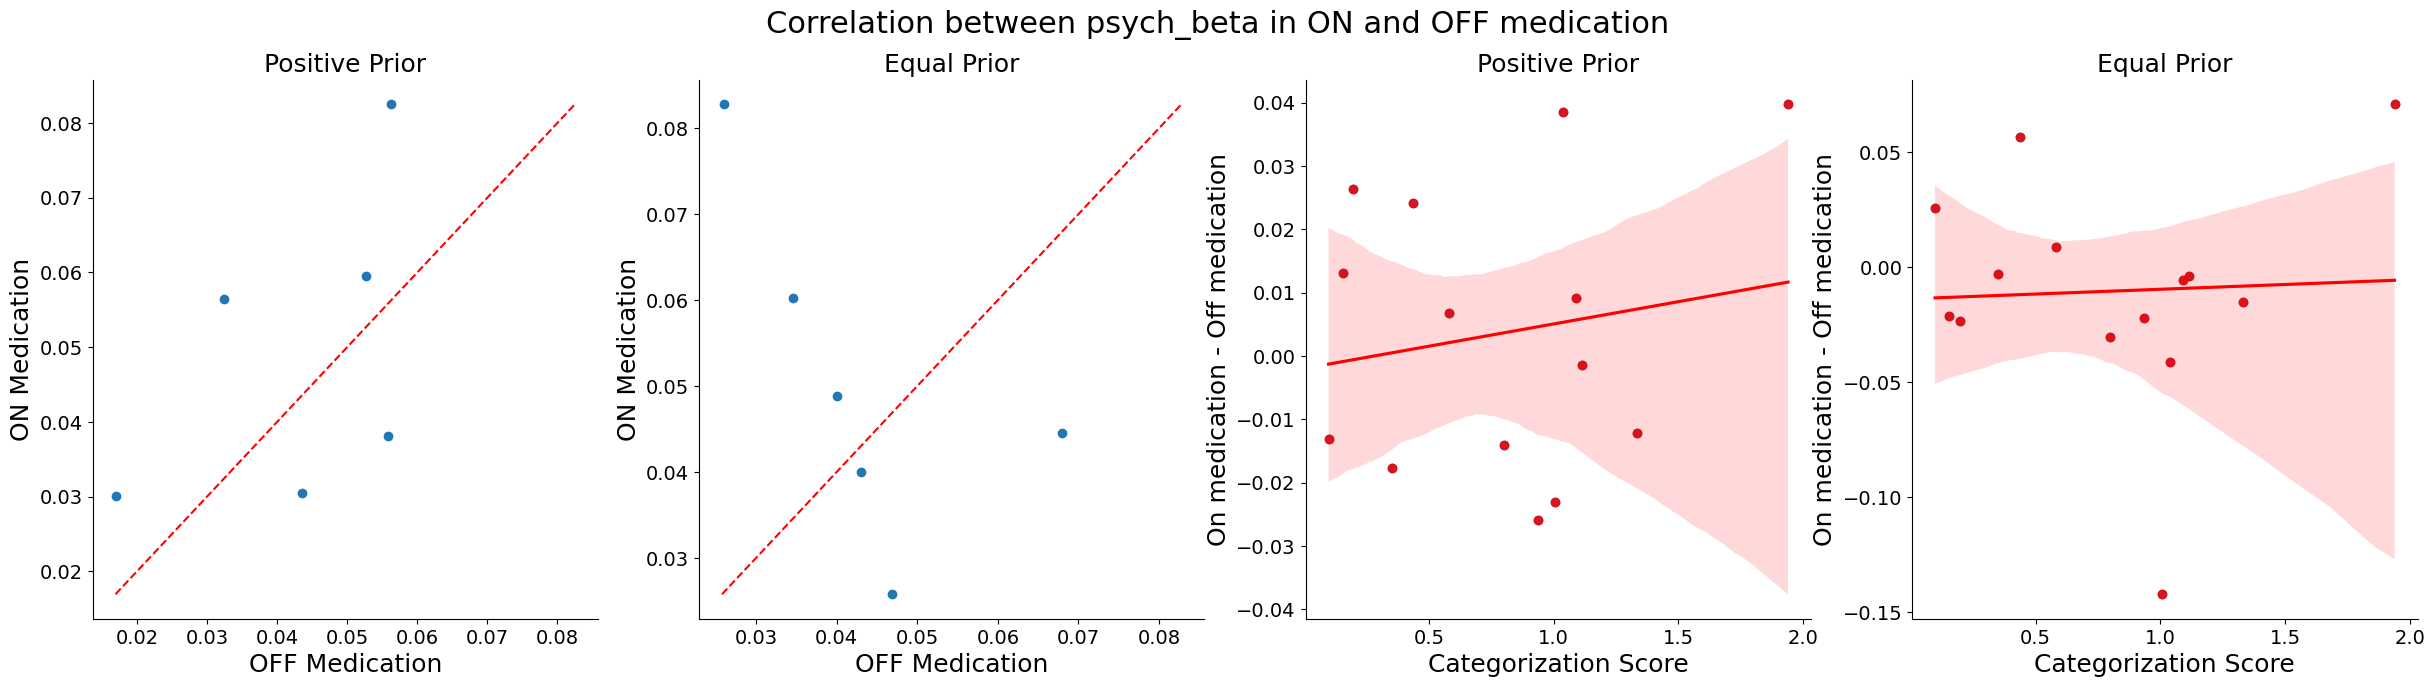

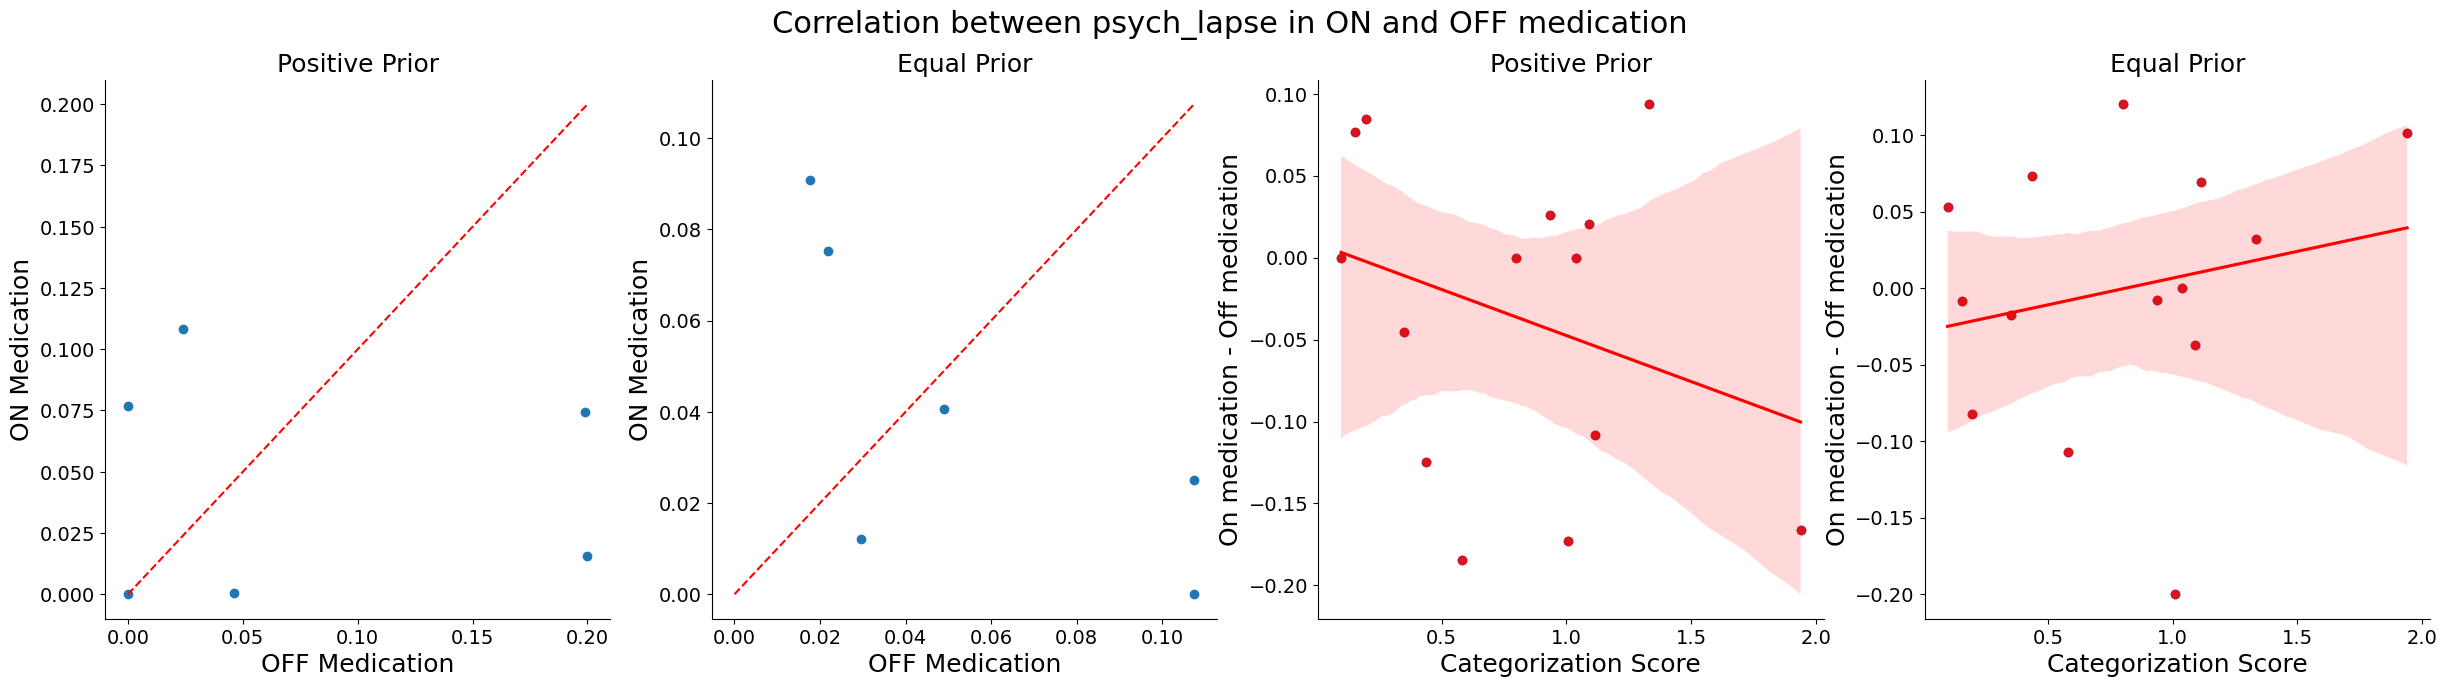

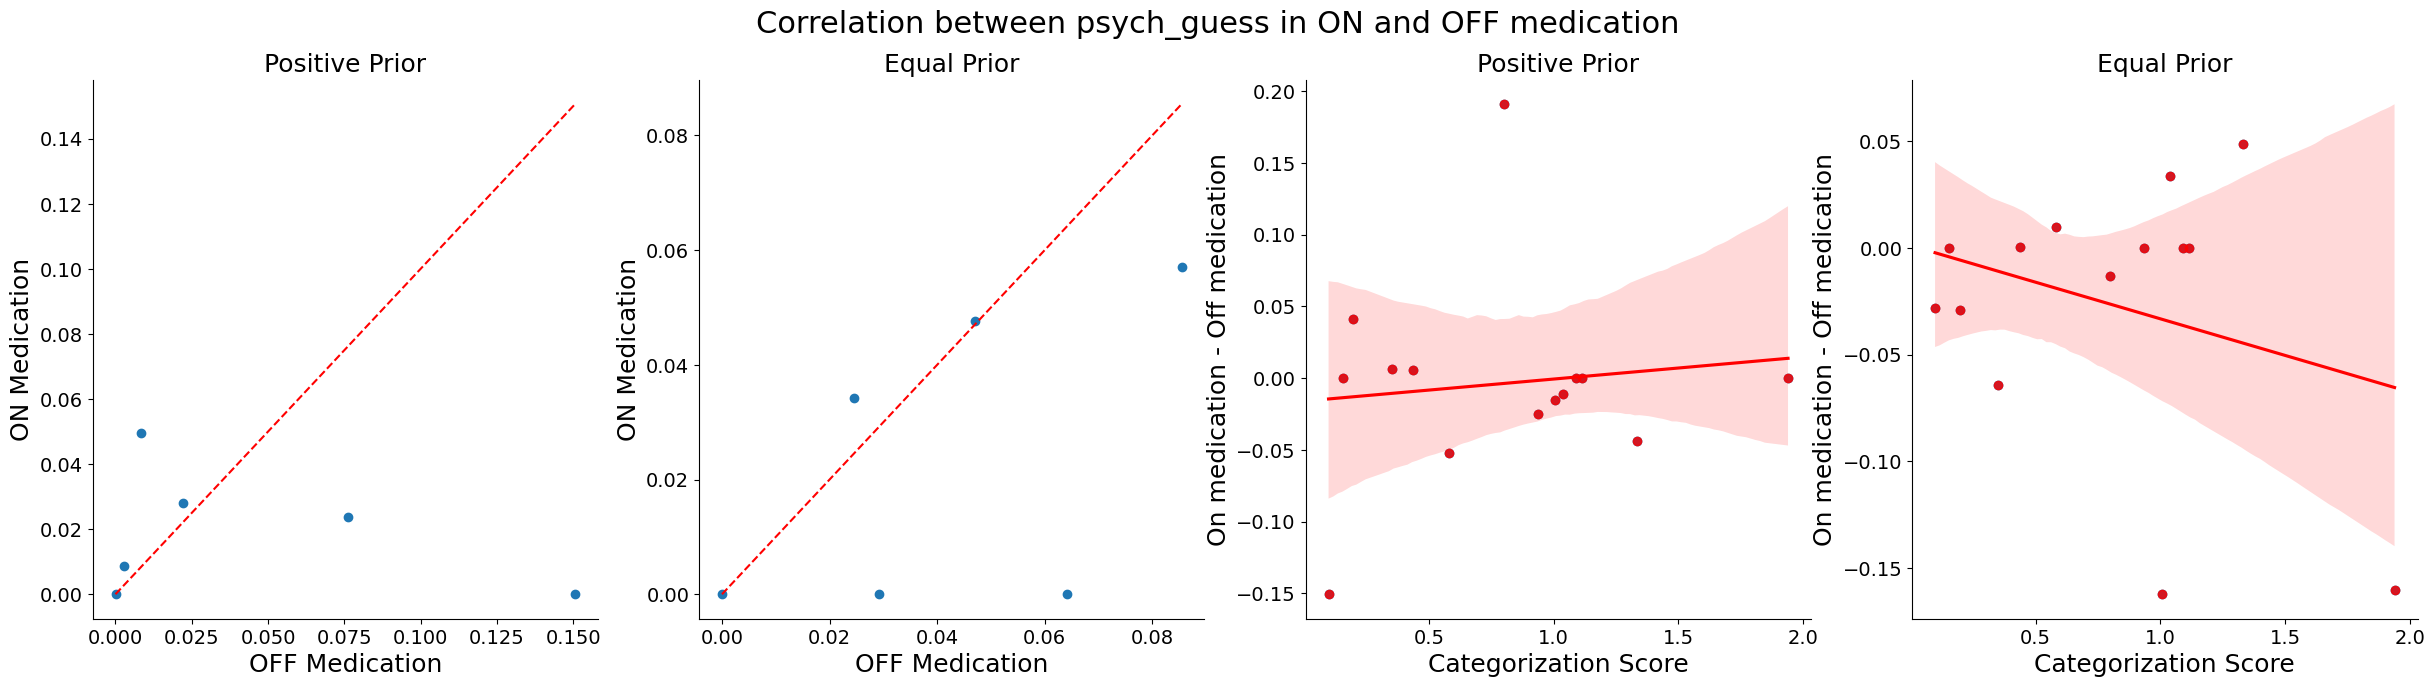

In [16]:
independent_variables = ['bias', 'psych_bias', 'psych_alpha', 'psych_beta', 'psych_lapse', 'psych_guess']

for independent_variable in independent_variables:

    fig, ax = plt.subplots(1, 4, figsize=(30, 7))
    ax[0].scatter(processed_metadata.loc[subject_treatment_idx['off']][f'positive_{independent_variable}'], processed_metadata.loc[subject_treatment_idx['on']][f'positive_{independent_variable}'])
    # get x_min, x_max, y_min, y_max
    x_min = min(processed_metadata.loc[subject_treatment_idx['off']][f'positive_{independent_variable}'].min(), processed_metadata.loc[subject_treatment_idx['on']][f'positive_{independent_variable}'].min())
    x_max = max(processed_metadata.loc[subject_treatment_idx['off']][f'positive_{independent_variable}'].max(), processed_metadata.loc[subject_treatment_idx['on']][f'positive_{independent_variable}'].max())
    y_min = min(processed_metadata.loc[subject_treatment_idx['off']][f'positive_{independent_variable}'].min(), processed_metadata.loc[subject_treatment_idx['on']][f'positive_{independent_variable}'].min())
    y_max = max(processed_metadata.loc[subject_treatment_idx['off']][f'positive_{independent_variable}'].max(), processed_metadata.loc[subject_treatment_idx['on']][f'positive_{independent_variable}'].max())
    ax[0].plot([x_min, x_max], [y_min, y_max], 'r--')
    ax[0].set_xlabel('OFF Medication', fontsize=18)
    ax[0].set_ylabel('ON Medication', fontsize=18)
    ax[0].set_title('Positive Prior', fontsize=18)    
    ax[0].tick_params(axis='both', labelsize=14)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)

    ax[1].scatter(processed_metadata.loc[subject_treatment_idx['off']][f'equal_{independent_variable}'], processed_metadata.loc[subject_treatment_idx['on']][f'equal_{independent_variable}'])
    # get x_min, x_max, y_min, y_max
    x_min = min(processed_metadata.loc[subject_treatment_idx['off']][f'equal_{independent_variable}'].min(), processed_metadata.loc[subject_treatment_idx['on']][f'equal_{independent_variable}'].min())
    x_max = max(processed_metadata.loc[subject_treatment_idx['off']][f'equal_{independent_variable}'].max(), processed_metadata.loc[subject_treatment_idx['on']][f'equal_{independent_variable}'].max())
    y_min = min(processed_metadata.loc[subject_treatment_idx['off']][f'equal_{independent_variable}'].min(), processed_metadata.loc[subject_treatment_idx['on']][f'equal_{independent_variable}'].min())
    y_max = max(processed_metadata.loc[subject_treatment_idx['off']][f'equal_{independent_variable}'].max(), processed_metadata.loc[subject_treatment_idx['on']][f'equal_{independent_variable}'].max())
    ax[1].plot([x_min, x_max], [y_min, y_max], 'r--')
    ax[1].set_xlabel('OFF Medication', fontsize=18)
    ax[1].set_ylabel('ON Medication', fontsize=18)
    ax[1].set_title('Equal Prior', fontsize=18)
    ax[1].tick_params(axis='both', labelsize=14)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    
    positive_diff = processed_metadata.loc[subtype_idx['on']][f'positive_{independent_variable}'].values - processed_metadata.loc[subtype_idx['off']][f'positive_{independent_variable}'].values
    ax[2].scatter(processed_metadata.loc[subtype_idx['off']]['categorization_score'], positive_diff)
    x_min = processed_metadata.loc[subtype_idx['off']]['categorization_score'].min()
    x_max = processed_metadata.loc[subtype_idx['off']]['categorization_score'].max()
    y_min = positive_diff.min()
    y_max = positive_diff.max()
    # plot regression line for the scatter plot
    sns.regplot(x=processed_metadata.loc[subtype_idx['off']]['categorization_score'], y=positive_diff, ax=ax[2], color='r')
    ax[2].set_xlabel('Categorization Score', fontsize=18)
    ax[2].set_ylabel('On medication - Off medication', fontsize=18)
    ax[2].set_title('Positive Prior', fontsize=18)    
    ax[2].tick_params(axis='both', labelsize=14)
    ax[2].spines['top'].set_visible(False)
    ax[2].spines['right'].set_visible(False)
    
    
    equal_diff = processed_metadata.loc[subtype_idx['on']][f'equal_{independent_variable}'].values - processed_metadata.loc[subtype_idx['off']][f'equal_{independent_variable}'].values
    ax[3].scatter(processed_metadata.loc[subtype_idx['off']]['categorization_score'], equal_diff)
    x_min = processed_metadata.loc[subtype_idx['off']]['categorization_score'].min()
    x_max = processed_metadata.loc[subtype_idx['off']]['categorization_score'].max()
    y_min = equal_diff.min()
    y_max = equal_diff.max()
    # plot regression line for the scatter plot
    sns.regplot(x=processed_metadata.loc[subtype_idx['off']]['categorization_score'], y=equal_diff, ax=ax[3], color='r')
    ax[3].set_xlabel('Categorization Score', fontsize=18)
    ax[3].set_ylabel('On medication - Off medication', fontsize=18)
    ax[3].set_title('Equal Prior', fontsize=18)    
    ax[3].tick_params(axis='both', labelsize=14)
    ax[3].spines['top'].set_visible(False)
    ax[3].spines['right'].set_visible(False)

    supertitle = f"Correlation between {independent_variable} in ON and OFF medication"
    fig.suptitle(supertitle, fontsize=22)

In [17]:
off_positive_alpha = processed_metadata.loc[subtype_idx['off']][f'positive_psych_alpha'].values
off_equal_alpha = processed_metadata.loc[subtype_idx['off']][f'equal_psych_alpha'].values

# stats.ttest_rel(off_positive_alpha, off_equal_alpha)
stats.sem(off_positive_alpha), stats.sem(off_equal_alpha)
# type(off_positive_alpha)

print(f"Positive Psychometric Alpha: {np.mean(off_positive_alpha):.2f} +/- {stats.sem(off_positive_alpha):.2f}")
print(f"Equal Psychometric Alpha: {np.mean(off_equal_alpha):.2f} +/- {stats.sem(off_equal_alpha):.2f}")
# print with only 2 decimal points
print(f"t-statistic: {stats.ttest_rel(off_positive_alpha, off_equal_alpha)[0]:.3f}, p-value: {stats.ttest_rel(off_positive_alpha, off_equal_alpha)[1]:.3f}")



Positive Psychometric Alpha: -7.34 +/- 5.22
Equal Psychometric Alpha: -6.81 +/- 6.66
t-statistic: -0.055, p-value: 0.957


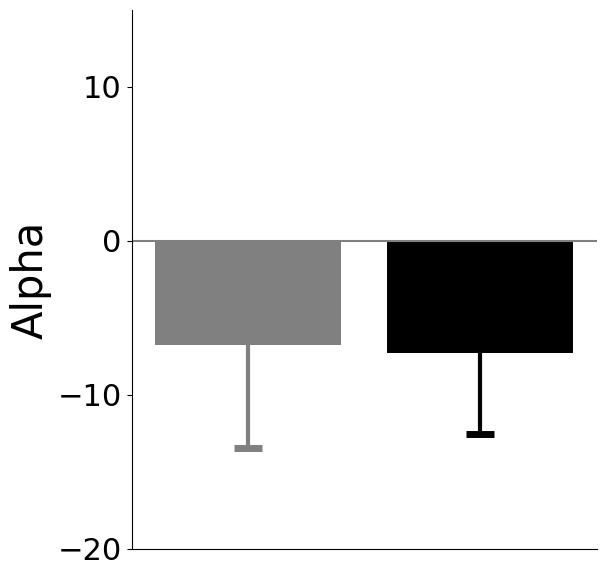

In [18]:
fig, ax = plt.subplots(1, figsize=(6, 7))
plt.bar([1], [np.mean(off_positive_alpha)], color=positive_color)
plt.bar([0], [np.mean(off_equal_alpha)], color=equal_color)
plt.errorbar([1], [np.mean(off_positive_alpha)], yerr=[stats.sem(off_positive_alpha)], color=positive_color, ls='', marker='', ms=12, mec='k', alpha=1, capsize=10, capthick=5, elinewidth=3, barsabove=True)
plt.errorbar([0], [np.mean(off_equal_alpha)], yerr=[stats.sem(off_equal_alpha)], color=equal_color, ls='', marker='', ms=12, mec='k', alpha=1, capsize=10, capthick=5, elinewidth=3, barsabove=True)
plt.hlines(0, -0.5, 1.5, color=[0.5, 0.5, 0.5], ls='-')
plt.xticks([])
plt.yticks([-20, -10, 0, 10, 20], fontsize=22)
plt.xlim(-0.5, 1.5)
plt.ylabel('Alpha', fontsize=30)
plt.ylim(-20, 15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.title('Psychometric Threshold', fontsize=25)
# plt.legend(fontsize=12)

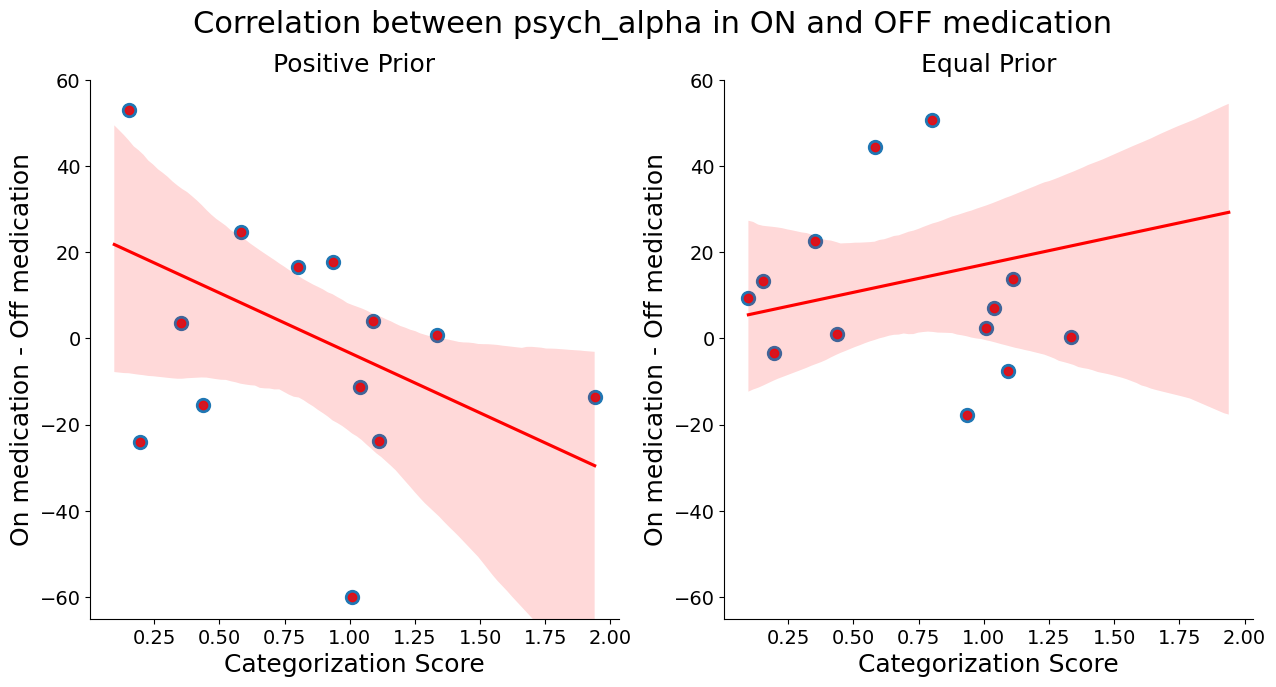

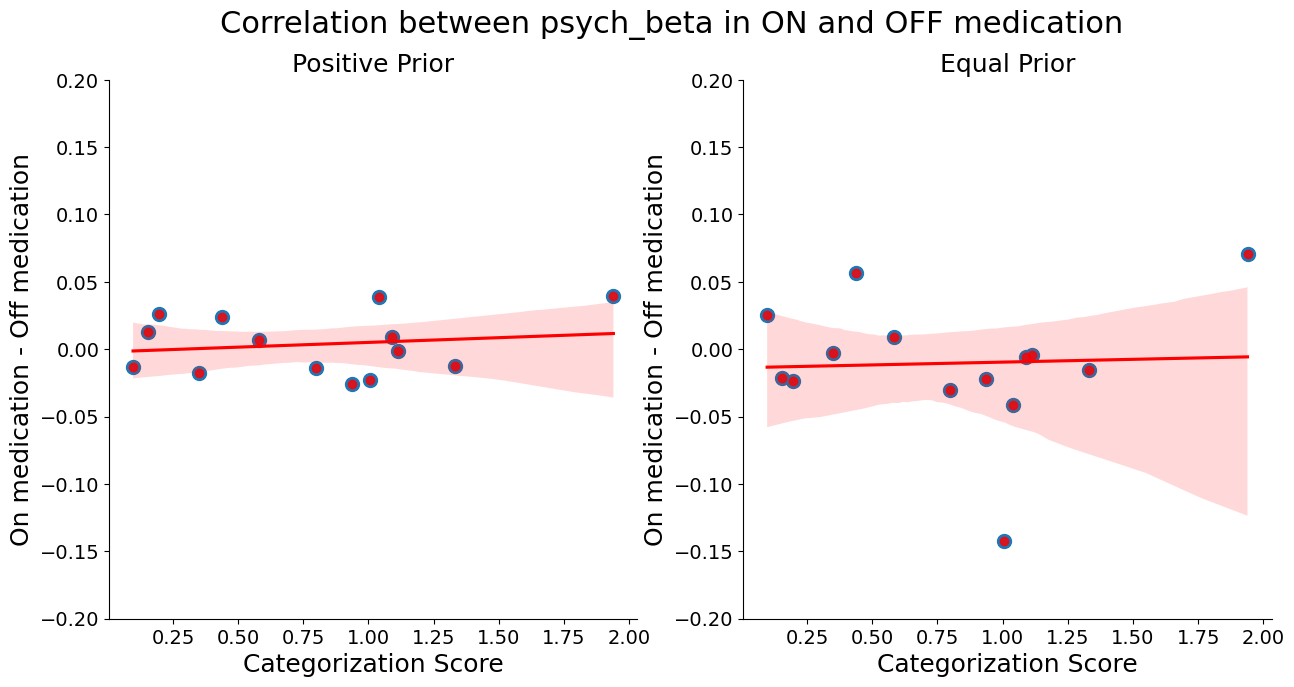

In [19]:

# independent_variables = ['bias', 'psych_bias', 'psych_alpha', 'psych_beta', 'psych_lapse', 'psych_guess']
independent_variables = ['psych_alpha', 'psych_beta']

for independent_variable in independent_variables:

    fig, ax = plt.subplots(1, 2, figsize=(15, 7))

    positive_diff = processed_metadata.loc[subtype_idx['on']][f'positive_{independent_variable}'].values - processed_metadata.loc[subtype_idx['off']][f'positive_{independent_variable}'].values
    ax[0].scatter(processed_metadata.loc[subtype_idx['off']]['categorization_score'], positive_diff, s=100)
    x_min = processed_metadata.loc[subtype_idx['off']]['categorization_score'].min()
    x_max = processed_metadata.loc[subtype_idx['off']]['categorization_score'].max()
    y_min = positive_diff.min()
    y_max = positive_diff.max()
    # plot regression line for the scatter plot
    sns.regplot(x=processed_metadata.loc[subtype_idx['off']]['categorization_score'], y=positive_diff, ax=ax[0], color='r')
    ax[0].set_xlabel('Categorization Score', fontsize=18)
    ax[0].set_ylabel('On medication - Off medication', fontsize=18)
    ax[0].set_title('Positive Prior', fontsize=18)
    
    ax[0].tick_params(axis='both', labelsize=14)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    
    equal_diff = processed_metadata.loc[subtype_idx['on']][f'equal_{independent_variable}'].values - processed_metadata.loc[subtype_idx['off']][f'equal_{independent_variable}'].values
    ax[1].scatter(processed_metadata.loc[subtype_idx['off']]['categorization_score'], equal_diff, s=100)
    x_min = processed_metadata.loc[subtype_idx['off']]['categorization_score'].min()
    x_max = processed_metadata.loc[subtype_idx['off']]['categorization_score'].max()
    y_min = equal_diff.min()
    y_max = equal_diff.max()
    # plot regression line for the scatter plot
    sns.regplot(x=processed_metadata.loc[subtype_idx['off']]['categorization_score'], y=equal_diff, ax=ax[1], color='r')
    ax[1].set_xlabel('Categorization Score', fontsize=18)
    ax[1].set_ylabel('On medication - Off medication', fontsize=18)
    ax[1].set_title('Equal Prior', fontsize=18)
    
    ax[1].tick_params(axis='both', labelsize=14)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    
    if independent_variable == 'psych_alpha':
        ax[0].set_ylim(-65, 60)
        ax[1].set_ylim(-65, 60)
    elif independent_variable == 'psych_beta':
        ax[0].set_ylim(-0.2, 0.2)
        ax[1].set_ylim(-0.2, 0.2)
        

    supertitle = f"Correlation between {independent_variable} in ON and OFF medication"
    fig.suptitle(supertitle, fontsize=22)

### Statistical Testing

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     categorization_score   R-squared:                       0.042
Model:                              OLS   Adj. R-squared:                 -0.001
Method:                   Least Squares   F-statistic:                    0.9756
Date:                  Tue, 14 Jan 2025   Prob (F-statistic):              0.334
Time:                          22:51:16   Log-Likelihood:                -12.682
No. Observations:                    24   AIC:                             29.36
Df Residuals:                        22   BIC:                             31.72
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9059      0.231      3.918      0.001       0.426       1.385
UPDRS         -0.0111      0.011     -0.988      0.334      -0.034       0.012
==============================================================================
Omnibus:                        9.737   Durbin-Watson:                   1.054
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                2.305
Skew:                          -0.212   Prob(JB):                        0.316
Kurtosis:                       1.542   Cond. No.                         54.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

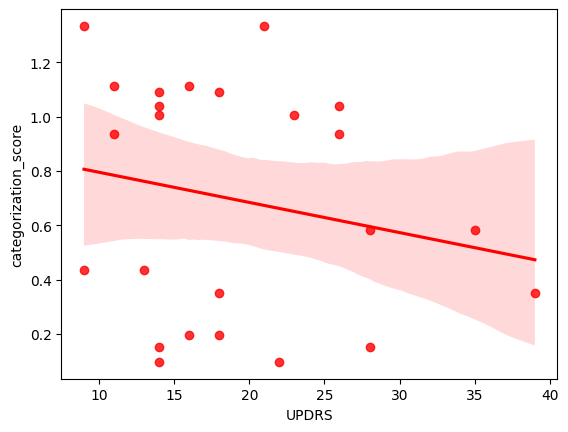

In [20]:
# Get indices where UPDRS score is not nan and categorization score is not nan
updrs_idx = processed_metadata.loc[~np.isnan(processed_metadata['UPDRS'])].index
categorization_idx = processed_metadata.loc[~np.isnan(processed_metadata['categorization_score'])].index
off_idx = processed_metadata.loc[processed_metadata['treatment'] == 'OFF'].index

common_idx = updrs_idx.intersection(categorization_idx)

sns.regplot(x=processed_metadata.loc[common_idx]['UPDRS'], y=processed_metadata.loc[common_idx]['categorization_score'], color='r')

sm.OLS(processed_metadata.loc[common_idx]['categorization_score'], sm.add_constant(processed_metadata.loc[common_idx]['UPDRS'])).fit().summary()

In [21]:
vars = ['positive_bias', 'positive_psych_bias', 'positive_psych_alpha', 'positive_psych_beta', 'positive_psych_lapse', 'positive_psych_guess', 
        'equal_bias', 'equal_psych_bias', 'equal_psych_alpha', 'equal_psych_beta', 'equal_psych_lapse', 'equal_psych_guess']

for var in vars:
    positive_diff = processed_metadata.loc[subtype_idx['on']][var].values - processed_metadata.loc[subtype_idx['off']][var].values
    pos_psych_model = sm.OLS(positive_diff, processed_metadata.loc[subtype_idx['off']]['categorization_score']).fit()
    pos_psych_model.summary()
    print(f"{var}: \t p-value: {pos_psych_model.pvalues[0].round(4)} \t R-squared: {pos_psych_model.rsquared.round(4)}")

positive_bias: 	 p-value: 0.7755 	 R-squared: 0.0065
positive_psych_bias: 	 p-value: 0.9216 	 R-squared: 0.0008
positive_psych_alpha: 	 p-value: 0.5281 	 R-squared: 0.0313
positive_psych_beta: 	 p-value: 0.4193 	 R-squared: 0.0508
positive_psych_lapse: 	 p-value: 0.0944 	 R-squared: 0.2003
positive_psych_guess: 	 p-value: 0.9645 	 R-squared: 0.0002
equal_bias: 	 p-value: 0.5413 	 R-squared: 0.0294
equal_psych_bias: 	 p-value: 0.5364 	 R-squared: 0.0301
equal_psych_alpha: 	 p-value: 0.0243 	 R-squared: 0.3331
equal_psych_beta: 	 p-value: 0.576 	 R-squared: 0.0247
equal_psych_lapse: 	 p-value: 0.7107 	 R-squared: 0.0109
equal_psych_guess: 	 p-value: 0.0765 	 R-squared: 0.2217
